In [1]:
# import the libraries
import requests
import csv
from bs4 import BeautifulSoup
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

### Convert model names to brands


In [2]:
# open the models file and use that to replace model names with brand names. 
# format of file is brand, model
#file = open('models.csv', 'r')
file = open('models.csv', 'r', encoding='mac_roman', newline='')

csv_file = csv.reader(file)

# store the brand names
brands = []
for i in csv_file:
    brands.append(i)
#     parsedData = parsedData.replace(i[1], i[0])

print('Finished storing this csv file into a list')
# close the file
file.close()

Finished storing this csv file into a list


In [3]:
unique_brands = []
for b in brands:
    if b[0] not in unique_brands:
        unique_brands.append(b[0])
unique_brands.remove('car')
unique_brands.remove('hyndai kia')
unique_brands.remove('hyundai,')
unique_brands.remove('hyundai.')
unique_brands.remove('kia,')
unique_brands.remove('kia.')
unique_brands.remove('mercedes benz')
unique_brands.remove('mercedes-benz')
unique_brands.remove('nissan.')
unique_brands.remove('problem')
unique_brands.remove('seat')
unique_brands.remove('toyata')
unique_brands.remove('volkwagen')

### Get comments

In [4]:
with open('finalcomments.csv') as f:
    data=[tuple(line) for line in csv.reader(f)]

### Get list of comments

In [5]:
comments = []

In [6]:
for c in data:
    comments.append(c[2])

### Get total number of comments

In [7]:
tot_number_of_comments = len(comments)

In [8]:
tot_number_of_comments

77080

### Get list of tuple of brand combinations

In [9]:
brand_combos = []
for i in range (len(unique_brands)):
    for j in range (len(unique_brands)):
        brand_combo = (unique_brands[i], unique_brands[j])
        brand_combos.append(brand_combo)

### Get dictionary of:
- {brand_combo: number of comments mentioning both brands}

In [10]:
brand_combo_dict = {}
for bc in brand_combos:
    brand_combo_dict[bc] = 0

In [11]:
for bc in brand_combos:
    for c in comments:
        brand1 = bc[0]
        brand2 = bc[1]
        if brand1 in c and brand2 in c:
            brand_combo_dict[bc] += 1


- {unique_brand: number of comments mentioning brand}<br>

In [12]:
unique_brands_dict = {}
for b in unique_brands:
    for c in comments:
        if b in c:
            if b in unique_brands_dict:
                unique_brands_dict[b] += 1
            else:
                unique_brands_dict[b] = 1

### Get top 10 brands

In [13]:
import operator
sorted_brands = sorted(unique_brands_dict.items(), key=operator.itemgetter(1))
sorted_brands.reverse()
sorted_brands[:10]

[('ford', 4115),
 ('dodge', 2709),
 ('chevrolet', 2563),
 ('bmw', 2364),
 ('honda', 2321),
 ('volkswagen', 2083),
 ('audi', 2060),
 ('mercedes', 1734),
 ('toyota', 1598),
 ('cadillac', 1564)]

### Calculate lift for each brand combo

In [14]:
# tot_number_of_comments
# unique_brands_dict
# brand_combo_dict

brand_combo_lifts_dict = {}
for bc in brand_combo_dict:
    if bc[0] == bc[1]:
        lift = 0
    else:
        combo_count = brand_combo_dict[bc]
        brand1_count = unique_brands_dict[bc[0]]
        brand2_count = unique_brands_dict[bc[1]]
        lift = (tot_number_of_comments * combo_count) / (brand1_count * brand2_count)
    brand_combo_lifts_dict[bc] = lift

### Matricies

In [15]:
matrix = []
row = -1
current_brand = ''
for combo in brand_combo_lifts_dict:
    brand = combo[0]
    lift = brand_combo_lifts_dict[combo]
    if brand == current_brand:
        matrix[row].append(lift)
    else:
        row += 1
        current_brand = brand
        matrix.append([])
        matrix[row].append(lift)

### Lift table

In [16]:
similarities = pd.DataFrame(matrix, columns=unique_brands, index=unique_brands)

In [17]:
similarities

,acura,audi,bmw,buick,cadillac,chevrolet,chrysler,dodge,ford,honda,...,mitsubishi,nissan,pontiac,saturn,sedan,subaru,suzuki,toyota,volkswagen,volvo
acura,0.000000,6.808655,6.300629,1.861836,5.555350,1.985571,12.862423,2.153471,1.990784,8.021696,...,5.841053,3.450240,1.770647,2.063793,4.597125,3.617063,0.000000,4.738088,2.323943,9.895862
audi,6.808655,0.000000,7.407521,2.089142,4.832692,1.927080,3.037343,2.002781,1.518522,3.288740,...,2.201028,2.236208,1.654696,1.244287,4.109710,3.500715,0.000000,2.575671,5.909913,6.222040
bmw,6.300629,7.407521,0.000000,2.472603,4.315467,2.391682,2.505969,2.058170,1.663963,2.725341,...,1.917985,1.722055,2.279147,0.851932,4.372419,3.400600,1.164491,2.632129,2.332337,5.199095
buick,1.861836,2.089142,2.472603,0.000000,5.503367,5.162726,2.607052,1.896887,1.763880,2.739810,...,1.511373,2.053324,4.123395,1.068013,5.004129,1.970348,2.294048,4.863725,1.696031,2.780030
cadillac,5.555350,4.832692,4.315467,5.503367,0.000000,3.499675,2.979164,1.928421,1.880333,2.144624,...,1.449526,2.328912,3.234035,0.819447,4.720679,1.511776,0.000000,2.498119,1.443263,3.592447
chevrolet,1.985571,1.927080,2.391682,5.162726,3.499675,0.000000,3.246344,2.808695,3.486114,2.591481,...,4.422666,2.445221,4.204372,1.285830,3.456797,2.398550,1.074076,3.481674,2.454442,2.466216
chrysler,12.862423,3.037343,2.505969,2.607052,2.979164,3.246344,0.000000,4.029656,3.429250,4.818005,...,7.047851,3.052926,2.658723,0.948642,5.015606,2.552264,4.754503,4.665244,2.844028,4.245479
dodge,2.153471,2.002781,2.058170,1.896887,1.928421,2.808695,4.029656,0.000000,2.323283,1.985970,...,4.184309,2.175027,2.516555,1.892381,2.652735,2.662042,2.032379,2.261308,1.830409,2.398114
ford,1.990784,1.518522,1.663963,1.763880,1.880333,3.486114,3.429250,2.323283,0.000000,2.001467,...,3.195368,2.421163,2.084243,1.423770,2.607574,2.815466,2.675924,2.391252,1.735561,2.133425
honda,8.021696,3.288740,2.725341,2.739810,2.144624,2.591481,4.818005,1.985970,2.001467,0.000000,...,2.930279,3.461761,2.273996,1.735430,4.029289,4.074825,1.186065,7.814076,2.375547,3.555494


### Turn similarities into dissimilarities

In [18]:
for i in range (len(matrix)):
    for j in range (len(matrix[i])):
        if matrix[i][j] != 0:
            matrix[i][j] = 1/matrix[i][j]

In [19]:
similarities = pd.DataFrame(matrix, columns=unique_brands, index=unique_brands)

### Plot MDS Map

In [20]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

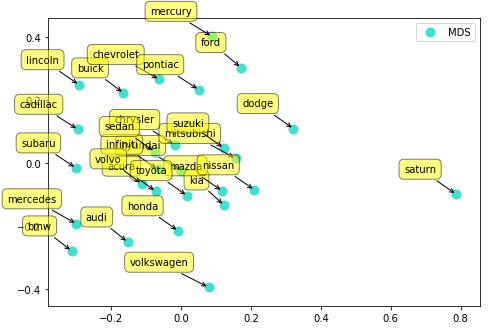

In [21]:
fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')

plt.legend(scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0

# Plot the edges
start_idx, end_idx = np.where(pos)

values = np.abs(similarities)

for label, x, y in zip(unique_brands, pos[:, 0], pos[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

### Do the same thing for top 10 brands by frequency

In [22]:
top_ten_brands = sorted_brands[:10]
top_ten_brands_list = []
for b in top_ten_brands:
    top_ten_brands_list.append(b[0])

#### Create top 10 brand combonations count dictionary

In [23]:
top_ten_brand_combos = []
for i in range (len(top_ten_brands_list)):
    for j in range (len(top_ten_brands_list)):
        brand_combo = (top_ten_brands_list[i], top_ten_brands_list[j])
        top_ten_brand_combos.append(brand_combo)

In [24]:
top_ten_brand_combo_dict = {}
for bc in top_ten_brand_combos:
    top_ten_brand_combo_dict[bc] = 0

In [25]:
for bc in top_ten_brand_combos:
    for c in comments:
        brand1 = bc[0]
        brand2 = bc[1]
        if brand1 in c and brand2 in c:
            top_ten_brand_combo_dict[bc] += 1

#### Create top 10 brand count dictionary

In [26]:
top_ten_brands_dict = {}
for b in top_ten_brands_list:
    for c in comments:
        if b in c:
            if b in top_ten_brands_dict:
                top_ten_brands_dict[b] += 1
            else:
                top_ten_brands_dict[b] = 1

#### Calculate lift for top 10 brands

In [27]:
# tot_number_of_comments
# top_ten_brands_dict
# top_ten_brand_combo_dict

top_ten_brand_combo_lifts_dict = {}
for bc in top_ten_brand_combo_dict:
    if bc[0] == bc[1]:
        lift = 0
    else:
        combo_count = top_ten_brand_combo_dict[bc]
        brand1_count = top_ten_brands_dict[bc[0]]
        brand2_count = top_ten_brands_dict[bc[1]]
        lift = (tot_number_of_comments * combo_count) / (brand1_count * brand2_count)
    top_ten_brand_combo_lifts_dict[bc] = lift

#### Lift Matrix

In [28]:
top_ten_matrix = []
row = -1
current_brand = ''
for combo in top_ten_brand_combo_lifts_dict:
    brand = combo[0]
    lift = top_ten_brand_combo_lifts_dict[combo]
    if brand == current_brand:
        top_ten_matrix[row].append(lift)
    else:
        row += 1
        current_brand = brand
        top_ten_matrix.append([])
        top_ten_matrix[row].append(lift)

### Lift table

In [33]:
similarities

,acura,audi,bmw,buick,cadillac,chevrolet,chrysler,dodge,ford,honda,...,mitsubishi,nissan,pontiac,saturn,sedan,subaru,suzuki,toyota,volkswagen,volvo
acura,0.000000,165.061447,150.116782,295.588235,153.604240,260.012195,100.000000,194.305382,342.148760,100.000000,...,831.696429,337.897059,401.823529,117.134915,251.926978,230.324974,0.000000,164.920434,254.305452,100.000000
audi,347.853279,0.000000,127.685111,263.427110,176.573488,267.904040,423.476205,208.924949,448.557431,243.913991,...,2207.142857,521.340629,429.981025,194.281743,281.805746,237.979976,0.000000,303.380204,100.000000,159.045287
bmw,375.901060,151.716952,0.000000,222.573846,197.736467,215.861702,513.271454,203.302374,409.350649,294.337367,...,2532.857143,676.996904,312.172869,283.757660,264.873950,244.986182,4171.764706,296.872839,253.390239,190.338164
buick,1272.084806,537.946311,382.524050,0.000000,155.055113,100.000000,493.370336,220.588235,386.162510,292.782901,...,3214.285714,567.774936,172.549020,226.347662,231.436837,422.818792,2117.647059,160.660302,348.455428,355.962370
cadillac,426.330136,232.550817,219.172113,100.000000,0.000000,147.520147,431.746032,216.981132,362.246671,374.037404,...,3351.428571,500.588235,220.000000,295.006453,245.333333,551.073826,0.000000,312.798336,409.482731,275.462963
chevrolet,1192.812204,583.186101,395.466453,106.598093,243.829845,0.000000,396.212560,148.976982,195.387841,309.541063,...,1098.428571,476.777275,169.225690,188.004787,335.032680,347.334796,4522.941176,224.434482,240.784409,401.256933
chrysler,184.134276,370.009774,377.430893,211.095391,286.431095,159.032000,0.000000,103.837877,198.627787,166.494134,...,689.285714,381.871658,267.605042,254.829743,230.907278,326.416107,1021.764706,167.495538,207.800807,233.091787
dodge,1099.812044,561.142927,459.548959,290.126279,442.499500,183.812253,319.194062,0.000000,293.181818,403.918411,...,1161.000000,536.005348,282.722960,127.744962,436.583400,312.955221,2390.294118,345.555642,322.873859,412.651782
ford,1189.688403,740.092254,568.420113,312.003486,453.816029,148.093990,375.079756,180.103291,0.000000,400.790868,...,1520.320197,481.514864,341.365008,169.790219,444.144630,295.901246,1815.441176,326.777674,340.518889,463.848631
honda,295.250883,341.725559,347.050203,200.866724,397.890354,199.219167,266.965723,210.693537,340.322581,0.000000,...,1657.857143,336.772549,312.879902,139.298124,287.430341,204.450503,4095.882353,100.000000,248.781195,278.325967


### Turn similarities into dissimilarities

In [29]:
for i in range (len(top_ten_matrix)):
    for j in range (len(top_ten_matrix[i])):
        if top_ten_matrix[i][j] != 0:
            top_ten_matrix[i][j] = 1/top_ten_matrix[i][j]

In [30]:
# find matrix of dissimilarites
d_similarities = pd.DataFrame(top_ten_matrix, columns=top_ten_brands_list, index=top_ten_brands_list)

### Plot MDS Map

In [31]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(d_similarities).embedding_

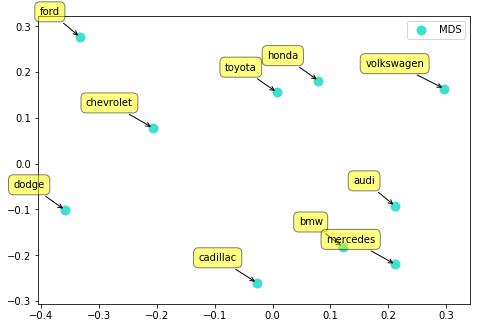

In [32]:
fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')

plt.legend(scatterpoints=1, loc='best', shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0

# Plot the edges
start_idx, end_idx = np.where(pos)

values = np.abs(similarities)

for label, x, y in zip(top_ten_brands_list, pos[:, 0], pos[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

_Aha moments:_<br>
<br>
To Dodge - Both Ford and Chevy are seen as your competitors. They both make sports cars and trucks like you. An interesting insight that our data suggests, however, is that Chevy is being compared to you much more than Ford is. This is unexpected. We can see this by looking at the MDS Map. Since the point for Chevy is closer to Dodge than the point for Ford, we know that more people talk about Chevy in conversation with Dodge than people bring up Ford.<br>
<br>
To Cadillac - Your brand reputation is normally seen as a(n) expensive brand; however, our data suggests that your brand is not talked together with the 3 other most popular expensive car brands (bmw, mercedes, audi). This should be brought to your attention if you see yourself as competitors to these three cars. Our data supports the statement that bmw, mercedes, and audi are strong competitors, but it suggest that you are not competing in their circle as much. One reason for this is that these three cars could be seen as more of performance cars, while Cadillac is seen as more of a luxury car. 